# Assignment 4: Prediction of renewable energy generation

## Context
A friend recently had to sign a new electricity supply contract. The high prices surprised him very much and he decided to look into the electricity market. Among a lot of other information, he learned that electricity is also traded on an exchange.
He found the so-called "day-ahead" market, where electricity is traded for the next day, the most interesting. He found out that the price is almost completely determined by the supply, because the demand hardly changes at such short notice (no private person turns on less light and no industrial company stops production at such short notice). He also found out that there are already very good forecasting models for this.
The electricity supply, on the other hand, has become much more exciting in recent years. Wind turbines and large photovoltaic plants have hardly any running costs and can therefore undercut any other power plant (in the short term). However, their production strongly depends on the current weather in the area where the respective plant is located. The "conventional" power plants, which then fill the gaps to demand, determine the electricity price based on their operating costs. If you know the current oil, coal and gas prices, this is also relatively easy to predict.

Meanwhile, he is sure that you could make good money if you had a good forecast of how much electricity wind power and PV will deliver. Since he has heard that you now have some experience with data analysis, he asks you to help him and to create a forecast model that predicts the amount of electricity produced (wind & photovoltaic) based on a weather report.

As he is aware that data is needed for this, he has already obtained data:
 - From "SMARTD" (part of the regulatory authority) the installed production capacity of the different types of power plants ("energy_installed_capacity.csv") and the amount of electricity produced in reality ("energy_produced.csv").
 - Daily records from the DWD (weather service) at many measuring stations. Two files, one with the measured values (weather.csv“), one with further information (e.g. location) of the measuring stations („weatherstations.csv“).
Both sources (all four data sets) cover the period from 2016 to 2021 inclusive.

He is also sure - if the model is good enough to be worthwhile - to be able to buy sufficiently good weather forecasts, no matter in which form they would be needed exactly. So there are no limititations how the data is groupped or preprocessed.

## Assignment

Develop a forecast model, evaluate it and answer the question whether it would be useful for the intended use!
Deliver a Jupyter notebook (able to run on the server) that includes the following parts:
- Data analysis and exploration, including preparation for the model. This includes (but not limited to):
  - understanding the data (continous/categorial, range of values ...)
  - unifying the time base
  - detecting and dealing missing data point
  - possibly necessary simplifications
- Develop and evaluate a model for the forecast.
- Conclude whether (at least on the basis of the data) a meaningfully usable forecasting model could be achieved. 

Also leave drafts steps in the Jupyter notebook so that we can understand your approach.
For each decision that is relevant to the result, give a brief justification, if not clear from the context. So after a parameter analysis comparable to Task 3 in Assignment 3, no justification would of course be needed for the choice of epochs and learning rate. No justification is necessary in an "exploratory phase" either, as these form the basis for later justifications.     

**Hints:**
 - Do not underestimate the importance of the data preprocessing.
 - Remember what we talked in the different lectures, where we have talked about different ways to solve different problems. For time reasons we often had just choosen one, but that one do not necesarily be the right one in this assignment.
 - The data is quite "raw", it has some faults and/or is not in the shape you may need it and can include unnecessary information.
 - Use your "common sense" especially during the preprocessing stage.
 - You can add an arbitrarily number of additional cells of course.
 - If you want to use additional python libraries, just ask, usually we will be able to provide them.
 - If you have more than one idea to solve a problem, allow yourself to experiment a bit! There is not only one solution but at the end make very clear what is your final result.
 - For EDA/Data Preparation and ANN there are total of 60 points. Roughly equal distributed, but depending where you make some decisions there can a bit movement.
 - For EDA/Data preparation you may consider, as an example, selecting the three measured parameters and compare the distribution of the values in terms of time, location, etc.

## Exploratory Data Analysis & Data preparation (~30 Points)


In [2]:
import pandas as pd 
import numpy as np 
import datetime

# keras imports for the dataset and building a neural network 
from keras.models import Sequential
from keras.layers import Dense

#sklearn imports for preprocessing 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
# importing neccessary data

# importing weather data
weather_df = pd.read_csv('weather.csv')

# after a lot of testing with the different data given, I got the best results for the NN with only using the average windspeed, max. windspeed, sunshine duration and cloud coverage
# #drop the useless data without 'good' influnce on the prediciton for energy_produced
weather_df_droplist= ['Minimum Temperature', 'Average Temperature', 'Maximum Temperature', 'relative humidity', 'average air preassure', 'Rain'] 
weather_df.drop( weather_df_droplist, inplace= True, axis = 1)


# importing energy produced data
ep_df = pd.read_csv('energy_produced.csv', sep= ';' )

#due to the task we only need PV and Wind, so the rest ist dropped 
ep_df_droplist= ['Water power[MW]','Biomass[MW]','Nuclear power[MW]','Brown coal[MW]','Coal[MW]','Natural gas[MW]','Pump storage[MW]','Other conventional[MW]', 'Other renewables[MW]'] 
ep_df.drop(ep_df_droplist, inplace= True, axis = 1)


# after testing the results where better, when the energy_installed_capacity is not used for the NN
# arguments for the bad influence on the results: very rough data compared to the energy produced with data per year, the capacity is already part of the energy produced data 
#eic_df= pd.read_csv('energy_installed_capacity.csv', sep = ';')
#only need PV and Wind 
#eic_df_droplist = ['Biomass[MW]', 'Water power[MW]','Other renewables[MW]', 'Nuclear power[MW]', 'Brown coal[MW]', 'Coal[MW]','Natural gas[MW]','Pump storage[MW]','Other conventional[MW]'] 
#eic_df.drop(eic_df_droplist, inplace = True, axis = 1)

# importing weather station data
ws_df = pd.read_csv('weatherstations.csv')
# drop the operator, because it's not neccessary
ws_df_droplist = ['Operator']
ws_df.drop(ws_df_droplist, inplace = True, axis= 1)

#converting date columnes from string to date type
ep_df['Date'] = pd.to_datetime(ep_df['Date'], format= '%d.%m.%Y')
weather_df['Date'] = pd.to_datetime(weather_df['Date'], format= '%Y-%m-%d')


In [4]:
#preprocessing the energery produced 

def preprocess_energy(ep_df):
    start_date = datetime.date(2016, 1, 1)   # setting start date for the loop, because there are more than one row per date
    end_date = datetime.date(2021, 12, 31)   # setting end date for loop #2021, 12, 31 subset of the given 
    delta = datetime.timedelta(days=1)       # time increase loop    
    
    onshore_list = []                        # lists to fill with data 
    offshore_list = []
    pv_list= []
    date_list = []

    while start_date <= end_date:           
        filt_ep = (ep_df['Date'] == start_date.strftime('%d.%m.%Y'))   # filter each day in given dataframe
        ep_date_mean = ep_df[filt_ep].mean(numeric_only = True)        # calculate the mean of each column for the filtered data, method mean skips values that are not available and includes zeros 
        offshore_list.append(ep_date_mean[0]*4)                        # storing the data, the mean value is for an interval of 15 minutes                                           #used for testing /eic_df.loc[start_date.strftime('%Y'),'Wind Offshore[MW]'].values[0])
        onshore_list.append(ep_date_mean[1]*4)                         # so we multiply it with 4 to get the average power produced in one hour                                      #used for testing /eic_df.loc[start_date.strftime('%Y'),'Wind Onshore[MW]'].values[0])   
        pv_list.append(ep_date_mean[2]*4)                              # but actually this is  we could stick to 15 minutes, als long as we use this interval for the whole programm #used for testing/eic_df.loc[start_date.strftime('%Y'),'Photovoltaics[MW]'].values[0])
        date_list.append(start_date)
        start_date += delta

    df = pd.DataFrame(zip(date_list, pv_list, offshore_list, onshore_list), columns= ['Date', 'average PV [MW/h]', 'average Offshore[MW/h]', 'average Onshore[MW/h]']) #building a new dataframe for further tasks
    return df

p_ep_df = preprocess_energy(ep_df)

In [5]:
# preprocessing the weather data 
def preprocess_weather(weather_df, ws_df, lat_list):
    
    station_list = []                     # collecting data of the station id 
    df_list = []                          # collecting dataframes 
    ws_df['geographic latitude'] = ws_df['geographic latitude'].astype(int) #convert type from float to int to filter
    
    for i in lat_list:
        filt_df = ws_df['geographic latitude'] == i                 # filter only stations with the lattitude i 
        df = ws_df[filt_df]                                         # apply filter to df 
        station_list = df['Stations_ID'].tolist()                   # filter station ids for the lattitude i 
        filt_df = weather_df['Stations_ID'].isin(station_list)      # create filter for station id to df 
        st_weather_df = weather_df[filt_df]                         # apply filter to df and save for next loop 
        
        start_date = datetime.date(2016, 1, 1)   # setting start date for the loop, because there are more than one row per date
        end_date = datetime.date(2021, 12, 31)   # setting end date for loop #2021, 12, 31 subset of the given 
        delta = datetime.timedelta(days=1)       # stepwidth for the loop, according to the stepwidth of your data   
    
        avg_wind_list = []
        max_wind_list = []
        sun_list= []
        cloud_list = []
        date_list = []

        while start_date <= end_date:
            filt_weather = (st_weather_df['Date'] == start_date.strftime('%d.%m.%Y'))        # filter each day in given dataframe
            weather_date_mean = st_weather_df[filt_weather].mean(numeric_only = True)        # calculate the mean of each column for the filtered data. 0 is != NaN, mean ignores missing values 
            avg_wind_list.append(weather_date_mean[1])                                       # collecting mean data for each 
            max_wind_list.append(weather_date_mean[2])   
            sun_list.append(weather_date_mean[3])
            cloud_list.append(weather_date_mean[4])
            date_list.append(start_date)
            df = pd.DataFrame(zip(date_list, avg_wind_list, max_wind_list, sun_list, cloud_list), columns= ['Date', 'Avg. Windspeed', 'Max. Windspeed', 'Sunshine duration', 'Cloud'])
            df = df.set_index('Date')
            start_date += delta
        
        df_list.append(df)
    
    df = pd.concat(df_list, axis = 1) # Merging the all the weather_df together 
    
    return df

lat_list = [47,48,49,50,51,52,53,54]  # list of all lattitudes in germany, to divide the weather data by lattitude 

p_weather_df = preprocess_weather(weather_df, ws_df, lat_list)

In [15]:
# create train, validation and test sets of the data 
weather_train_raw, weather_val_raw, ep_train_raw, ep_val_raw = train_test_split(p_weather_df , p_ep_df.set_index('Date'), test_size = 0.3) #split the whole data to train and validation sets
weather_val_raw, weather_test_raw, ep_val_raw, ep_test_raw = train_test_split(weather_val_raw , ep_val_raw, test_size = 0.3)                       #split the validation data to validation and test sets

# normalizing the data 
def scaler_array(input_df):                                               
    output_array = input_df.to_numpy()                                  # use numpy.array instead of dataframe, according to keras documentation dataframes are not supported
    min_max_scaler = preprocessing.MinMaxScaler()                       # creating the scaler for the array
    scaled_output_array = min_max_scaler.fit_transform(output_array)    # transform to values between 0 to 1 for the array 
    
    return scaled_output_array, min_max_scaler

weather_train, min_max_scaler_weather_train = scaler_array(weather_train_raw)     
ep_train, min_max_scaler_ep_train = scaler_array(ep_train_raw)

weather_val, min_max_scaler_weather_val = scaler_array(weather_val_raw)
ep_val, min_max_scaler_ep_val = scaler_array(ep_val_raw)

weather_test , min_max_scaler_weather_test = scaler_array(weather_test_raw)
ep_test , min_max_scaler_ep_test= scaler_array(ep_test_raw)

## Developing and evaluation of the ANN (~30 Points)


In [48]:
# Build a ANN 
# after testing I decieded for the following parameters, probably you would get better results with more testing and developing. But for this case the results are good enough.

def get_model(training_input, training_output):
    model = Sequential()
    model.add(Dense(200, activation= 'relu', input_shape = training_input[0].shape))
    model.add(Dense(100, activation= 'relu'))
    model.add(Dense(20, activation= 'sigmoid'))
    model.add(Dense(training_output[0].shape[0]))

    model.compile(loss= 'mae', optimizer="adam", metrics= "mse")
    return model

def fit_model(training_input, training_output, model, num_epochs):
    history = model.fit(training_input, training_output, epochs = num_epochs, verbose= 2 , validation_data=(weather_val, ep_val))
    return history

model = get_model(weather_train, ep_train)

history = fit_model(weather_train, ep_train, model, 80)


Epoch 1/80


2022-03-15 16:42:20.584349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 - 1s - loss: 0.2888 - mse: 0.1836 - val_loss: 0.1405 - val_mse: 0.0318


2022-03-15 16:42:21.136712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/80
48/48 - 0s - loss: 0.0939 - mse: 0.0174 - val_loss: 0.0856 - val_mse: 0.0149
Epoch 3/80
48/48 - 0s - loss: 0.0771 - mse: 0.0127 - val_loss: 0.0810 - val_mse: 0.0134
Epoch 4/80
48/48 - 0s - loss: 0.0732 - mse: 0.0116 - val_loss: 0.0763 - val_mse: 0.0122
Epoch 5/80
48/48 - 0s - loss: 0.0719 - mse: 0.0110 - val_loss: 0.0750 - val_mse: 0.0120
Epoch 6/80
48/48 - 0s - loss: 0.0718 - mse: 0.0108 - val_loss: 0.0764 - val_mse: 0.0117
Epoch 7/80
48/48 - 0s - loss: 0.0694 - mse: 0.0103 - val_loss: 0.0745 - val_mse: 0.0115
Epoch 8/80
48/48 - 0s - loss: 0.0684 - mse: 0.0101 - val_loss: 0.0710 - val_mse: 0.0107
Epoch 9/80
48/48 - 0s - loss: 0.0678 - mse: 0.0100 - val_loss: 0.0707 - val_mse: 0.0117
Epoch 10/80
48/48 - 0s - loss: 0.0676 - mse: 0.0098 - val_loss: 0.0744 - val_mse: 0.0113
Epoch 11/80
48/48 - 0s - loss: 0.0682 - mse: 0.0098 - val_loss: 0.0724 - val_mse: 0.0107
Epoch 12/80
48/48 - 0s - loss: 0.0672 - mse: 0.0098 - val_loss: 0.0831 - val_mse: 0.0121
Epoch 13/80
48/48 - 0s - loss

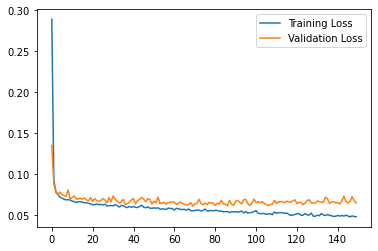

In [47]:
from matplotlib import pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

print()

In [50]:
# Predicting power produced tomorrow
# Based on the task a NN was developed to predict the mean amount of energy produced in one day

def predict_energy(weather_test, safety_factor): 

    ep_predict = model.predict(weather_test)                                # predict the energy produced for a weatherforecast or in our case for the unused dataset
    ep_predict = ep_predict - safety_factor                                 # our model is not perfect, so its possible to enter a safety factor for the prediction                                 
    ep_result = min_max_scaler_ep_test.inverse_transform(ep_predict)        # inverse the normalization 
    ep_result_df = pd.DataFrame(data = ep_result, columns= ['average PV [MW/h]', 'average Offshore [MW/h]', 'average Onshore [MW/h]'])
    ep_combined = ep_result_df.sum(axis = 1)
    return ep_result_df, ep_combined

ep_result_df, ep_combined = predict_energy(weather_test, 0)
                         
# when you use a weatherforecast and the predicted value is lower than todays average combined value of the three power sources for one hour, then you should ,according to the assumptions in the given task, buy today an sell tommorow
print(ep_result_df)
print(ep_test_raw)

     average PV [MW/h]  average Offshore [MW/h]  average Onshore [MW/h]
0          2196.411377              2950.186035            11059.463867
1          2470.471191              4624.850098            22566.523438
2          7382.674316              4258.292969            15877.634766
3          2963.649658              4653.599609            22846.736328
4          4036.397949               988.192505             9361.403320
..                 ...                      ...                     ...
193        2560.116943              3988.576172            20516.017578
194        5343.837402              4369.635742            10768.210938
195        1204.038940              2760.857910             5495.749512
196        8247.177734              1688.717285             6084.687012
197        1956.985352              4245.028809            29533.435547

[198 rows x 3 columns]
            average PV [MW/h]  average Offshore[MW/h]  average Onshore[MW/h]
Date                               

## Summary (10 Points)

Is this model usable for predicting the amount of generated renewable energy based on weather data?

First I want to make a quick recap of the task and the approach of the developed programm to solve this task. The task was to create a programm to predict the amount of electricity production of PV and wind power of the next day with a good weatherforecast/weather report. 

For the development of the programm the data got preprocessed to:
  - a unifiyed time base (one day, average electricity produced in one hour over the timespan of one day)
  - missing data points where deteced, the method mean(numeric only = True) only uses data that is numerical to calculate the mean (Datapoints like NaN or NULL are dropped). For the energy the programm uses the average over one day, so if one datapoint is missing there are still enough datapoints to result in a reliable datapoint. For the weather data the programm calculates the average over all stations of the same lattitude, the missing data is ignored for the calculation of the average.
  - For simplifications in the programm a lot of datapoints that were given in the dataset are not used, the best reason for that were the better results for the reduced datasets. Also in the programm only average values are used in the NN, because the NN doesn't care if the values are summed up over the whole day or given in averages of one hour. It's only important to be consistend with the units that are used.
  - During the development I was sure, that it's neccessary to use the enegery installed capacity. But then I tested the ANN without the use the dataset for the energy installed capacity and the error decreased by around 40%. Then I realised the problems with that dataset. First the time base is to rough for use. If you would, like I did, divide the energy produced through the energy installed capacity there will be a big difference between the 31.12 and the 01.01 but not between the 01.01. and the 02.01. although the difference is only one day. Another point I realised is the influence of the capacity is already included in data of the energy produced, because the amount of i.E. PV power that is produced is always effected by the amount of PV power plants installed, so there is no reason to include this data a second time. 

Then a ANN for the forecast was developed:
For the ANN i sticked to a simple three layered ANN. My first approach was to build a simple ANN and try it with the preprocessed data and the results where pretty good with an MAE of the validation data where around 0,26. Then I played around with different parameters as epochs, number of dense layers, size of dense layers, activations function and then I did the same again with reduced datasets and then without the energy installed capacity included. What I learned from the different tries is that: 
  - the number of epochs has not a big influence on the results, the MAE of the validation data doesn't decrease anymore than a little bit under 0.08, no matter if you use 10 epochs or 100 (as seen in
  plot above)
  - For the activation function the best results where with relu, I think the reason for that is that the solution should be a value between 0 and 1, so sigmoid and linear (both could also result in  negativ outputs) where not the right choice. The results for tanh where also not as good as with relu, so I decided to stick with relu
  - the influence of more dense layers with different sizes and activation functions where underwhelming the best results, for no combination i got a significant better result than with one hidden layer and a size of 200. 
  - the biggest improvement where, when i decided to reduced the data of the input by decreasing the amount of meassured data in the training set. I started dropping the data for Minimum Temperature, Average Temperature, Maximum Temperature, relative humidity, average air preassure and Rain till i got the best results for the error. So I sticked with only average windspeed, max. windspeed, sunshine duration and cloud coverage. 
  - then i tried the ANN without the data of the enegergy installed capacity and the error decreased further. 

  At the end I got a MAE of arround 0.08.
  
In my opinion this model is useable to predict the amount of generated wind and pv power based on the given weather data. 

But there is one point to be discussed before the unrestricted use in the real world. How acurate are weather forecasts for the needed parameters? In the dataset we used to train and test the model, we had datasets with historic values for the weather, but how accurate can you predict the windspeed for each lattitude? So I'm pretty sure there are some errors in the weather report for tommorow. When you have an error in the model and have also an error in the forecast the combined error will increase. The increased error could make our model unuseable to predict the energy. So before I would use this model in reality, I would "buy sufficiently good weather forecasts" and test it before using it. 
